In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tensorflow.keras.models import save_model

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/archive/PotatoPlants",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
n_class = len(class_names)
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0]


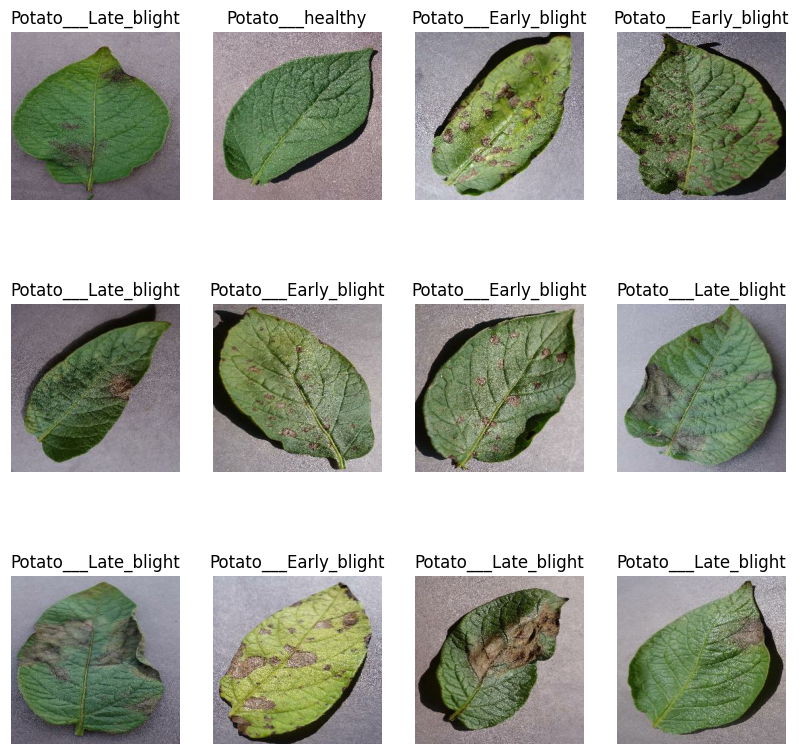

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def get_data_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_data_partition(dataset)

In [10]:
# Train and Validation: Shuffle before caching
train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Test: No shuffling
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [13]:
CHANNEL = 3
BATCH_SIZE = 32
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])
model.build(input_shape = input_shape)

model.summary()

D:\Program\Anaconda\envs\tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 25088)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 128)                   │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 3)                     │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,855,235 (7.08 MB)

 Trainable params: 1,855,235 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=20,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 674ms/step - accuracy: 0.4850 - loss: 0.9554 - val_accuracy: 0.7865 - val_loss: 0.5921
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 683ms/step - accuracy: 0.8125 - loss: 0.5344 - val_accuracy: 0.7135 - val_loss: 0.7858
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 670ms/step - accuracy: 0.8285 - loss: 0.4987 - val_accuracy: 0.8802 - val_loss: 0.2903
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 697ms/step - accuracy: 0.8947 - loss: 0.2341 - val_accuracy: 0.8854 - val_loss: 0.2417
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 0.9378 - loss: 0.1600 - val_accuracy: 0.9167 - val_loss: 0.2289
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 745ms/step - accuracy: 0.9430 - loss: 0.1507 - val_accuracy: 0.8802 - val_loss: 0.2700
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 663ms/step - accuracy: 0.9365 - loss: 0.1629 - val_accuracy: 0.8385 - val_loss: 0.4370
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 671ms/step - accuracy: 0.9259 - loss: 0.1817 - val_accu

In [16]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8593 - loss: 0.3260


[0.43686339259147644, 0.84375]

In [18]:
# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_ds)
# Evaluate on Validation Set
val_loss, val_accuracy = model.evaluate(val_ds)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8593 - loss: 0.3260
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9169 - loss: 0.2120
Test Accuracy: 84.38%
Validation Accuracy: 90.62%


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

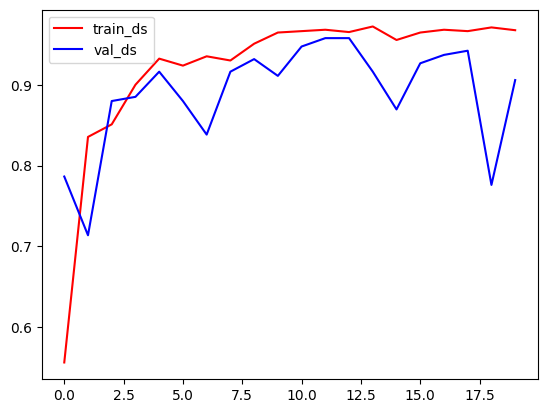

In [20]:
plt.plot(history.history['accuracy'], color='red', label='train_ds')
plt.plot(history.history['val_accuracy'], color='blue', label='val_ds')
plt.legend()
plt.show()

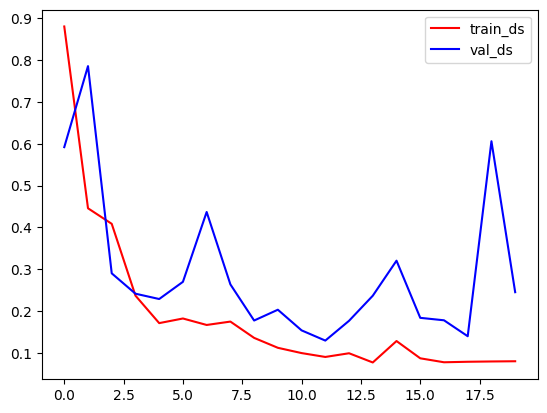

In [21]:
plt.plot(history.history['loss'], color='red', label='train_ds')
plt.plot(history.history['val_loss'], color='blue', label='val_ds')
plt.legend()
plt.show()

First image to predict
Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted label: Potato___Early_blight


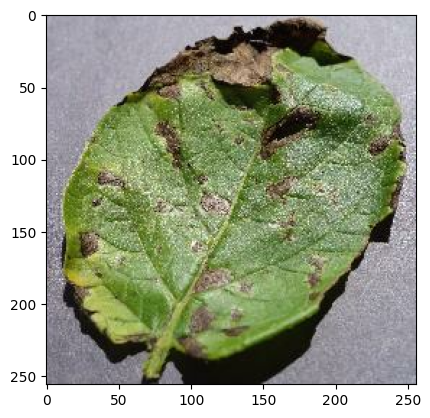

In [22]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    # img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class}\n Confidence: {confidence}%')
        plt.axis('off')

In [ ]:
# # Save model in HDF5 format
# model.save("new_model.h5")

# # (Optional) Show confirmation
# print("✅ Pruned model saved as 'new_model.h5'")

In [41]:
import numpy as np

def calculate_flops_custom(model, input_shape):
    flops = 0
    height, width, in_channels = input_shape[1:]  # skip batch size

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            kernel_h, kernel_w = layer.kernel_size
            out_channels = layer.filters
            strides = layer.strides
            padding = layer.padding

            if padding == 'same':
                out_height = int(np.ceil(height / strides[0]))
                out_width = int(np.ceil(width / strides[1]))
            else:
                out_height = int(np.ceil((height - kernel_h + 1) / strides[0]))
                out_width = int(np.ceil((width - kernel_w + 1) / strides[1]))

            conv_flops = 2 * out_height * out_width * in_channels * out_channels * (kernel_h * kernel_w)
            flops += conv_flops

            height, width, in_channels = out_height, out_width, out_channels

        elif isinstance(layer, tf.keras.layers.Dense):
            input_shape_tensor = tf.keras.backend.int_shape(layer.input)
            output_units = layer.units
            input_units = input_shape_tensor[-1] if input_shape_tensor else 0
            dense_flops = 2 * input_units * output_units
            flops += dense_flops

        elif isinstance(layer, tf.keras.layers.ReLU) or (hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu):
            output_shape_tensor = tf.keras.backend.int_shape(layer.output)
            if output_shape_tensor:
                output_units = np.prod(output_shape_tensor[1:])
                flops += output_units

    return flops
    
# Call after building the model
# custom_flops = calculate_flops_custom(model, input_shape)
# print(f"🔹 Estimated FLOPs: {custom_flops:,}")

# ---- METRICS CALCULATION ----

# 1. Total Parameters
total_params = model.count_params()
print(f"\n🔹 Total Parameters: {total_params:,}")

# 2. Custom FLOPs
custom_flops = calculate_flops_custom(model, input_shape)
print(f"🔹 Estimated FLOPs: {custom_flops:,}")

# 3. Inference Time
sample_input = tf.random.normal([1, *input_shape[1:]])
start_time = time.time()
_ = model(sample_input)
end_time = time.time()
inference_time = (end_time - start_time) * 1000
print(f"🔹 Inference Time: {inference_time:.3f} ms per sample")

# 4. Model Size
model.save("temp_model.keras", save_format='keras')  # avoid legacy HDF5 warning
model_size = os.path.getsize("temp_model.keras") / (1024 * 1024)
print(f"🔹 Model Size: {model_size:.2f} MB")

# Clean up
os.remove("temp_model.keras")


🔹 Total Parameters: 1,855,235
🔹 Estimated FLOPs: 29,809,991,168
🔹 Inference Time: 37.009 ms per sample
🔹 Model Size: 21.30 MB


**Prunning**

In [ ]:
# import numpy as np
# from tensorflow.keras import layers, models

# def prune_conv_layer(layer, keep_ratio=0.5):
#     weights, biases = layer.get_weights()  # shape: (kH, kW, inC, outC)
#     l1_norms = np.sum(np.abs(weights), axis=(0, 1, 2))
    
#     num_keep = int(keep_ratio * weights.shape[-1])
#     top_k_indices = np.argsort(l1_norms)[-num_keep:]
    
#     pruned_weights = weights[:, :, :, top_k_indices]
#     pruned_biases = biases[top_k_indices]
    
#     return pruned_weights, pruned_biases, num_keep

# # Original Conv2D filter counts: 32 → 64 → 128 → 128
# # Pruning 50% filters
# conv1_w, conv1_b, f1 = prune_conv_layer(model.layers[2], 0.5)
# conv2_w, conv2_b, f2 = prune_conv_layer(model.layers[4], 0.5)
# conv3_w, conv3_b, f3 = prune_conv_layer(model.layers[6], 0.5)
# conv4_w, conv4_b, f4 = prune_conv_layer(model.layers[8], 0.5)

# # Build pruned model
# pruned_model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(f1, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(f2, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(f3, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(f4, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(n_class, activation='softmax')
# ])

# # Build and set pruned weights
# pruned_model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))
# pruned_model.layers[2].set_weights([conv1_w, conv1_b])
# pruned_model.layers[4].set_weights([conv2_w, conv2_b])
# pruned_model.layers[6].set_weights([conv3_w, conv3_b])
# pruned_model.layers[8].set_weights([conv4_w, conv4_b])

# # Summary
# pruned_model.summary()

In [27]:
import numpy as np
from tensorflow.keras import layers, models

def prune_conv_layer(layer, keep_ratio=0.5, prev_layer_indices=None):
    weights, biases = layer.get_weights()  # shape: (kH, kW, inC, outC)
    l1_norms = np.sum(np.abs(weights), axis=(0, 1, 2))
    
    num_keep = int(keep_ratio * weights.shape[-1])
    top_k_indices = np.argsort(l1_norms)[-num_keep:]
    
    # Prune output channels
    pruned_weights = weights[:, :, :, top_k_indices]
    pruned_biases = biases[top_k_indices]
    
    # If the previous layer was pruned, adjust input channels
    if prev_layer_indices is not None:
        pruned_weights = pruned_weights[:, :, prev_layer_indices, :]
    
    return pruned_weights, pruned_biases, num_keep, top_k_indices

# Assuming original model has Conv2D layers at indices 2, 4, 6, 8
# Prune layers sequentially, passing the indices of kept filters to the next layer
conv1_w, conv1_b, f1, indices1 = prune_conv_layer(model.layers[2], 0.5)
conv2_w, conv2_b, f2, indices2 = prune_conv_layer(model.layers[4], 0.5, prev_layer_indices=indices1)
conv3_w, conv3_b, f3, indices3 = prune_conv_layer(model.layers[6], 0.5, prev_layer_indices=indices2)
conv4_w, conv4_b, f4, indices4 = prune_conv_layer(model.layers[8], 0.5, prev_layer_indices=indices3)

# Build pruned model
pruned_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(f1, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(f2, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(f3, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(f4, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])

# Build and set pruned weights
pruned_model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))
pruned_model.layers[2].set_weights([conv1_w, conv1_b])
pruned_model.layers[4].set_weights([conv2_w, conv2_b])
pruned_model.layers[6].set_weights([conv3_w, conv3_b])
pruned_model.layers[8].set_weights([conv4_w, conv4_b])

# Summary
pruned_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 254, 254, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 127, 127, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 125, 125, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 62, 62, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 60, 60, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 12544)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 64)                    │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 128)                   │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (32, 3)                     │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 872,099 (3.33 MB)

 Trainable params: 872,099 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import numpy as np
from tensorflow.keras import layers, models

# Define constants (assumed from your notebook)
IMAGE_SIZE = 256  # From your notebook
CHANNEL = 3       # RGB images
n_class = 3       # From your notebook: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
BATCH_SIZE = 32   # From your notebook

# Example preprocessing layers (replace with your actual definitions)
resize_and_rescale = layers.Rescaling(1./255)  # Updated: No 'experimental'
data_augmentation = layers.RandomFlip("horizontal")

# Updated pruning function to propagate pruning across layers
def prune_conv_layer(layer, prev_kept_indices=None, keep_ratio=0.5):
    weights, biases = layer.get_weights()  # shape: (kH, kW, inC, outC)
    if prev_kept_indices is not None:
        # Prune input channels based on the previous layer's kept filters
        weights = weights[:, :, prev_kept_indices, :]
    l1_norms = np.sum(np.abs(weights), axis=(0, 1, 2))  # L1 norm over height, width, input channels
    num_keep = int(keep_ratio * weights.shape[-1])  # Number of filters to keep
    top_k_indices = np.argsort(l1_norms)[-num_keep:]  # Indices of top filters by L1 norm
    
    pruned_weights = weights[:, :, :, top_k_indices]  # Prune output channels
    pruned_biases = biases[top_k_indices]
    
    return pruned_weights, pruned_biases, top_k_indices

# Assuming 'model' is your original trained model with structure:
# [resize_and_rescale, data_augmentation, Conv2D(32), MaxPooling2D, Conv2D(64), MaxPooling2D, 
#  Conv2D(128), MaxPooling2D, Conv2D(128), MaxPooling2D, Flatten, Dense(64), Dense(128), Dense(3)]
# Prune layers with propagation
conv1_w, conv1_b, idx1 = prune_conv_layer(model.layers[2], None, 0.5)  # First Conv2D: 32 -> 16
conv2_w, conv2_b, idx2 = prune_conv_layer(model.layers[4], idx1, 0.5)  # Second Conv2D: 64 -> 32
conv3_w, conv3_b, idx3 = prune_conv_layer(model.layers[6], idx2, 0.5)  # Third Conv2D: 128 -> 64
conv4_w, conv4_b, idx4 = prune_conv_layer(model.layers[8], idx3, 0.5)  # Fourth Conv2D: 128 -> 64

# Get the number of filters after pruning
f1 = conv1_w.shape[-1]  # e.g., 16
f2 = conv2_w.shape[-1]  # e.g., 32
f3 = conv3_w.shape[-1]  # e.g., 64
f4 = conv4_w.shape[-1]  # e.g., 64

# Build pruned model
pruned_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(f1, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(f2, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(f3, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(f4, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])

# Build the model with correct input shape (batch size as None)
pruned_model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))

# Set pruned weights
pruned_model.layers[2].set_weights([conv1_w, conv1_b])  # First Conv2D
pruned_model.layers[4].set_weights([conv2_w, conv2_b])  # Second Conv2D
pruned_model.layers[6].set_weights([conv3_w, conv3_b])  # Third Conv2D
pruned_model.layers[8].set_weights([conv4_w, conv4_b])  # Fourth Conv2D

# Display model summary
pruned_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 872,099 (3.33 MB)

 Trainable params: 872,099 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
pruned_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Pruned_history = pruned_model.fit(
    train_ds,
    epochs=20,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.7913 - loss: 0.4498 - val_accuracy: 0.9531 - val_loss: 0.1112
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.9666 - loss: 0.0962 - val_accuracy: 0.9479 - val_loss: 0.1523
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9720 - loss: 0.0850 - val_accuracy: 0.9792 - val_loss: 0.0465
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9727 - loss: 0.0710 - val_accuracy: 0.9844 - val_loss: 0.0388
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9817 - loss: 0.0493 - val_accuracy: 0.9844 - val_loss: 0.0489
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9822 - loss: 0.0440 - val_accuracy: 0.9792 - val_loss: 0.0386
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9808 - loss: 0.0554 - val_accuracy: 0.9844 - val_loss: 0.0558
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9823 - loss: 0.0543 - val_accu

In [30]:
# Evaluate on test set
test_loss, test_accuracy = pruned_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Optional: Save the trained pruned model
# pruned_model.save('pruned_potato_model.h5')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9910 - loss: 0.0185
Test Loss: 0.0195, Test Accuracy: 0.9883


In [31]:
import numpy as np
import tensorflow as tf
import time
import os

# -----------------------------
# 👉 Change here: use model or pruned_model
model_to_analyze = pruned_model
# input_shape = (32, 256, 256, 3)  # with batch size (for inference)
input_shape = (None, 256, 256, 3)  # for FLOPs calculation (batch-independent)
# -----------------------------

def calculate_flops_custom(model, input_shape):
    flops = 0
    height, width, in_channels = input_shape[1:]  # skip batch size

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            kernel_h, kernel_w = layer.kernel_size
            out_channels = layer.filters
            strides = layer.strides
            padding = layer.padding

            if padding == 'same':
                out_height = int(np.ceil(height / strides[0]))
                out_width = int(np.ceil(width / strides[1]))
            else:
                out_height = int(np.ceil((height - kernel_h + 1) / strides[0]))
                out_width = int(np.ceil((width - kernel_w + 1) / strides[1]))

            conv_flops = 2 * out_height * out_width * in_channels * out_channels * (kernel_h * kernel_w)
            flops += conv_flops

            height, width, in_channels = out_height, out_width, out_channels

        elif isinstance(layer, tf.keras.layers.Dense):
            input_shape_tensor = tf.keras.backend.int_shape(layer.input)
            output_units = layer.units
            input_units = input_shape_tensor[-1] if input_shape_tensor else 0
            dense_flops = 2 * input_units * output_units
            flops += dense_flops

        elif isinstance(layer, tf.keras.layers.ReLU) or (hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu):
            output_shape_tensor = tf.keras.backend.int_shape(layer.output)
            if output_shape_tensor:
                output_units = np.prod(output_shape_tensor[1:])
                flops += output_units

    return flops

# --- METRICS ---

# 1. Total Parameters
total_params = model_to_analyze.count_params()
print(f"\n🔹 Total Parameters: {total_params:,}")

# 2. FLOPs
custom_flops = calculate_flops_custom(model_to_analyze, input_shape)
print(f"🔹 Estimated FLOPs: {custom_flops:,}")

# 3. Inference Time
sample_input = tf.random.normal([1, 256, 256, 3])  # batch size = 1
start_time = time.time()
_ = model_to_analyze(sample_input, training=False)
end_time = time.time()
inference_time = (end_time - start_time) * 1000
print(f"🔹 Inference Time: {inference_time:.3f} ms per sample")

# 4. Model Size
model_to_analyze.save("temp_model.keras", save_format='keras')
model_size = os.path.getsize("temp_model.keras") / (1024 * 1024)
print(f"🔹 Model Size: {model_size:.2f} MB")

# Cleanup
os.remove("temp_model.keras")


🔹 Total Parameters: 872,099
🔹 Estimated FLOPs: 7,481,184,384
🔹 Inference Time: 23.695 ms per sample
🔹 Model Size: 10.04 MB


**KD**

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import time
import os

# Define constants (from your notebook)
IMAGE_SIZE = 256
BATCH_SIZE = 32
n_class = 3
CHANNEL = 3

# Teacher model (original model from your notebook)
teacher_model = model  # Assuming 'model' is the original trained model

# Define a new student model (smaller than teacher)
student_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])

# Build the student model
student_model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))

# KD parameters
TEMPERATURE = 5.0  # Temperature for softening logits
ALPHA = 0.7       # Weight for KD loss vs. ground truth loss

# Custom KD loss function
def kd_loss(y_true, y_pred, teacher_logits, temperature=TEMPERATURE, alpha=ALPHA):
    """
    Compute Knowledge Distillation loss:
    - alpha * KL-divergence between softened teacher and student logits
    - (1-alpha) * Cross-entropy with ground truth
    """
    student_soft = tf.nn.softmax(y_pred / temperature, axis=-1)
    teacher_soft = tf.nn.softmax(teacher_logits / temperature, axis=-1)
    
    kd_loss = tf.keras.losses.KLDivergence()(
        teacher_soft, student_soft
    ) * (temperature ** 2)  # Scale by T^2
    
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred)
    
    return alpha * kd_loss + (1.0 - alpha) * ce_loss

# Custom Keras Model for KD
class KDModel(tf.keras.Model):
    def __init__(self, student, teacher, temperature, alpha):
        super(KDModel, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        
    def compile(self, optimizer, metrics, kd_loss_fn):
        super(KDModel, self).compile(optimizer=optimizer, metrics=metrics)
        self.kd_loss_fn = kd_loss_fn
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape(persistent=False) as tape:
            teacher_logits = self.teacher(x, training=False)
            student_logits = self.student(x, training=True)
            loss = self.kd_loss_fn(y, student_logits, teacher_logits, 
                                 temperature=self.temperature, alpha=self.alpha)
        
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.compiled_metrics.update_state(y, tf.nn.softmax(student_logits, axis=-1))
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self.student(x, training=False)
        self.compiled_metrics.update_state(y, tf.nn.softmax(y_pred, axis=-1))
        return {m.name: m.result() for m in self.metrics}

# Instantiate and compile KD model
kd_model = KDModel(student=student_model, teacher=teacher_model, 
                   temperature=TEMPERATURE, alpha=ALPHA)
kd_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
    kd_loss_fn=kd_loss
)

# Train the student with KD
kd_history = kd_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    ]
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.4975 - loss: 0.3333 - val_loss: 0.3333
Epoch 2/20


D:\Program\Anaconda\envs\tensorflow\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,val_loss
  current = self.get_monitor_value(logs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.8460 - loss: 0.3333 - val_loss: 0.3333
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.8913 - loss: 0.3333 - val_loss: 0.3333
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 306ms/step - accuracy: 0.9292 - loss: 0.3333 - val_loss: 0.3333
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 306ms/step - accuracy: 0.9356 - loss: 0.3333 - val_loss: 0.3333
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 323ms/step - accuracy: 0.9598 - loss: 0.3333 - val_loss: 0.3333
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.9519 - loss: 0.3333 - val_loss: 0.3333
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.9353 - loss: 0.3333 - val_loss: 0.3333
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.9568 - loss: 0.3333 - val_loss: 0.3333
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 339ms/step - accuracy: 0.9696 - loss: 0.3333 - val_loss: 0.3333
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 322ms/step - 

In [38]:
student_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,710,243 (14.15 MB)

 Trainable params: 3,710,243 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Compute metrics (parameters, FLOPs, inference time, model size)
def calculate_flops_custom(model, input_shape):
    flops = 0
    height, width, in_channels = input_shape[1:]
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            kernel_h, kernel_w = layer.kernel_size
            out_channels = layer.filters
            strides = layer.strides
            padding = layer.padding
            if padding == 'same':
                out_height = int(np.ceil(height / strides[0]))
                out_width = int(np.ceil(width / strides[1]))
            else:
                out_height = int(np.ceil((height - kernel_h + 1) / strides[0]))
                out_width = int(np.ceil((width - kernel_w + 1) / strides[1]))
            conv_flops = 2 * out_height * out_width * in_channels * out_channels * (kernel_h * kernel_w)
            flops += conv_flops
            height, width, in_channels = out_height, out_width, out_channels
        elif isinstance(layer, tf.keras.layers.Dense):
            input_shape_tensor = tf.keras.backend.int_shape(layer.input)
            output_units = layer.units
            input_units = input_shape_tensor[-1] if input_shape_tensor else 0
            dense_flops = 2 * input_units * output_units
            flops += conv_flops
        elif isinstance(layer, tf.keras.layers.ReLU) or (hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu):
            output_shape_tensor = tf.keras.backend.int_shape(layer.output)
            if output_shape_tensor:
                output_units = np.prod(output_shape_tensor[1:])
                flops += output_units
    return flops

# Metrics
total_params = student_model.count_params()
custom_flops = calculate_flops_custom(student_model, (None, 256, 256, 3))
sample_input = tf.random.normal([1, 256, 256, 3])
start_time = time.time()
_ = student_model(sample_input, training=False)
inference_time = (time.time() - start_time) * 1000
student_model.save("temp_kd_student.keras")
model_size = os.path.getsize("temp_kd_student.keras") / (1024 * 1024)
os.remove("temp_kd_student.keras")

print(f"\nKD Student Model Metrics:")
print(f"🔹 Total Parameters: {total_params:,}")
print(f"🔹 Estimated FLOPs: {custom_flops:,}")
print(f"🔹 Inference Time: {inference_time:.3f} ms per sample")
print(f"🔹 Model Size: {model_size:.2f} MB")

# Optional: Save the KD-trained student model
student_model.save('kd_student_potato_model.keras')


KD Student Model Metrics:
🔹 Total Parameters: 3,710,243
🔹 Estimated FLOPs: 7,552,994,688
🔹 Inference Time: 15.534 ms per sample
🔹 Model Size: 14.19 MB
